## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [80]:
import string
import os

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [81]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [82]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [83]:
tokens = sorted(set(text))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [84]:
# dict <index>:<char>
# Your great code here
index_token = dict(zip(range(len(tokens)), tokens))

# dict <char>:<index>
# Your great code here
token_index = dict(zip(tokens, range(len(tokens))))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [85]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.lin = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.lin(out)
        return out, hidden

    def initial_state(self, batch_size):
        return Variable(torch.zeros(1, batch_size, self.num_units)).to(device)

In [86]:
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = int(len(arr) / batch_size_total)
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
          y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y # returning generator, cause we have no need to iterate it twice


In [87]:

def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

In [88]:


def train(net, train_text, val_text, epochs=100, show_epoch=10, batch_size=10,
          seq_length=50, lr=0.001, clip=5,
          lstm=False):

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loss_epoch, val_loss_epoch = list(), list()
    n_chars = len(tokens)
    for e in range(epochs):
        h = net.initial_state(batch_size)
        for x, y in get_batches(train_text, batch_size, seq_length):
            net.train()
            x = one_hot_encode(x, n_chars)
            inputs = torch.from_numpy(x).to(device)
            targets = torch.from_numpy(y).to(device)
            net.zero_grad()
            if lstm:
                h = tuple([each.data for each in h])
            else:
                h = h.detach()

            output, h = net(inputs, h)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
        if e == 0 or (e+1) % show_epoch == 0:
            val_h = net.initial_state(batch_size)
            val_losses = []
            net.eval()
            for x, y in get_batches(val_text, batch_size, seq_length):
                x = one_hot_encode(x, n_chars)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                if lstm:
                    val_h = tuple([each.data for each in val_h])
                else:
                    val_h = val_h.detach()

                inputs, targets = x, y
                inputs, targets = inputs.to(device), targets.to(device)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                val_losses.append(val_loss.item())
                train_loss_epoch.append(loss.item())
                val_loss_epoch.append(np.mean(val_losses))
                print(f'Epoch {e + 1} of {epochs}: training loss: {train_loss_epoch[-1]:.6f}; validation loss: {val_loss_epoch[-1]:.6f}')
        elif lstm:
            print(f'Epoch {e + 1} of {epochs}')

    return train_loss_epoch, val_loss_epoch

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [89]:
def plot_train_process(train_loss, val_loss, epoch_gap=1):
    fig, axes = plt.subplots(1, 1,figsize=(15,5))
    axes.set_title("Loss")
    axes.plot(train_loss, label='train')
    axes.plot(val_loss, label='test')
    axes.grid()
    axes.set_xlabel('n epoch * {}'.format(epoch_gap))
    axes.legend()
    axes.plot()

In [90]:
def predict(net, char, h=None, temperature=0.2, lstm=False):
        x = np.array([[token_index[char]]])
        x = one_hot_encode(x, len(tokens))
        inputs = torch.from_numpy(x).to(device)
        if lstm:
            h = tuple([each.data for each in h])
        else:
            h = h.detach()

        out, h = net(inputs, h)

        p = F.softmax(out/temperature, dim=1).data
        p = p.cpu().numpy().squeeze()
        char = np.random.choice(len(tokens), p=p/p.sum())
        return index_token[char], h

In [91]:


def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0, lstm=False):
    char_rnn.to(device)
    char_rnn.eval()

    chars_generated = [ch for ch in seed_phrase]
    h = char_rnn.initial_state(1)
    
    #feed the seed phrase, if any
    for ch in seed_phrase:
        char, h = predict(char_rnn, ch, h, temperature, lstm=lstm)
    
    #start generating
    chars_generated.append(char)
    while len(chars_generated) < max_length:
        char, h = predict(char_rnn, chars_generated[-1], h, temperature, lstm)
        chars_generated.append(char)
        
    return ''.join(chars_generated)

In [92]:
encoded = np.array([token_index[ch] for ch in text])
split_index = int(len(encoded)*0.9)
encoded_text_train, encoded_text_val = encoded[:split_index], encoded[split_index:]

In [94]:
# finally, let's train it

n_epoch = 100
epoch_gap = 10

net = CharRNNLoop(len(tokens), rnn_num_units=256,emb_size=38).to(device)
train_loss, val_loss = train(net, encoded_text_train, encoded_text_val,
                             epochs=n_epoch, show_epoch=epoch_gap,
                             batch_size=100, seq_length=100)

Epoch 1 of 100: training loss: 3.067672; validation loss: 3.026427
Epoch 10 of 100: training loss: 2.609823; validation loss: 2.613243
Epoch 20 of 100: training loss: 2.212741; validation loss: 2.251881
Epoch 30 of 100: training loss: 2.072690; validation loss: 2.127614
Epoch 40 of 100: training loss: 1.994394; validation loss: 2.076776
Epoch 50 of 100: training loss: 1.931923; validation loss: 2.034992
Epoch 60 of 100: training loss: 1.871995; validation loss: 1.992570
Epoch 70 of 100: training loss: 1.816117; validation loss: 1.960583
Epoch 80 of 100: training loss: 1.768119; validation loss: 1.930465
Epoch 90 of 100: training loss: 1.720121; validation loss: 1.919357
Epoch 100 of 100: training loss: 1.684877; validation loss: 1.900968


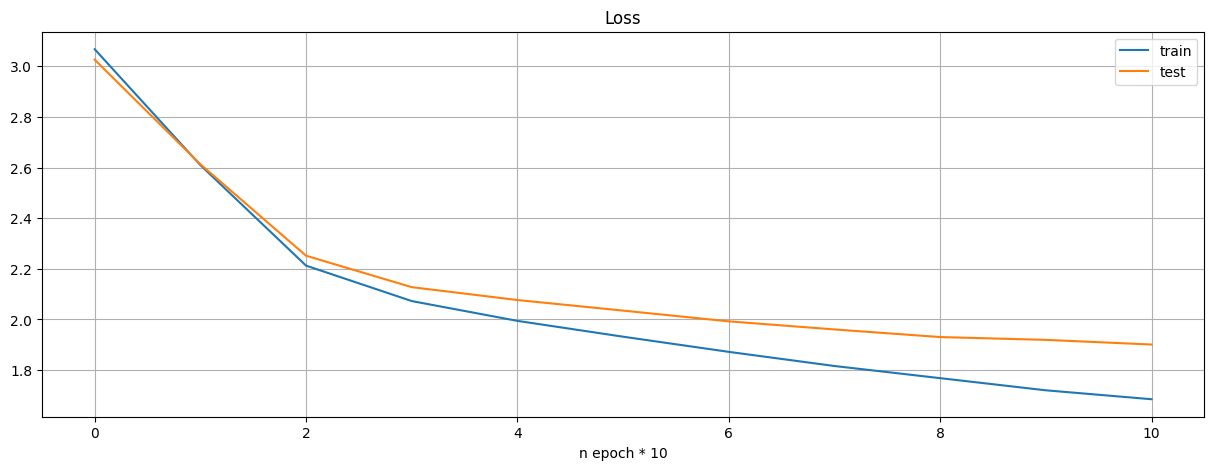

In [95]:
plot_train_process(train_loss, val_loss, epoch_gap)

In [96]:
# An example of generated text.
print(generate_sample(net, seed_phrase='love ', max_length=500, temperature=0.2))

love thee the rearte thee the reare,
  and the reart the store thee the sealle in the erees my deather thee,
  and the routh the sore the serent in thee thee thee thee thee thee the herece,
  and the sear the will the searte thou detser'd are thee thee the seare
  and then in the seal thou are the with the will the prowe,
  and the sear and the sour and beauty stean thee thee the singe
  the right i faines of the with the searte thee thee the conder chanke,
  and the sore thit the will the storn


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [97]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2, dropout=0.5)
        self.lin = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.lin(out)
        return out, hidden

    def initial_state(self, batch_size):
        return (Variable(torch.zeros(2, batch_size, self.num_units)).to(device),
                Variable(torch.zeros(2, batch_size, self.num_units)).to(device))

Plot the loss function of the number of epochs. Does the final loss become better?

In [99]:
# Your beautiful code here

n_epoch = 100
epoch_gap = 10

net = CharLSTMLoop(len(tokens), rnn_num_units=512, emb_size=38).to(device)
train_loss, val_loss = train(net, encoded_text_train, encoded_text_val,
                             epochs=n_epoch, show_epoch=epoch_gap,
                             batch_size=100, seq_length=100, lstm=True)

Epoch 1 of 100: training loss: 3.065560; validation loss: 3.064130
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100: training loss: 2.907520; validation loss: 2.906600
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100: training loss: 2.264558; validation loss: 2.283691
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100: training loss: 1.957091; validation loss: 2.029875
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100: training loss: 1.773114; validation loss: 1.878077
Epoch 41 of 100
Epoch 42 of 100
Epoch 43 of 100
Epoch 44 of 100
Epoch 45 of 100
Epoch 46 of 100
Epoch 47 of 1

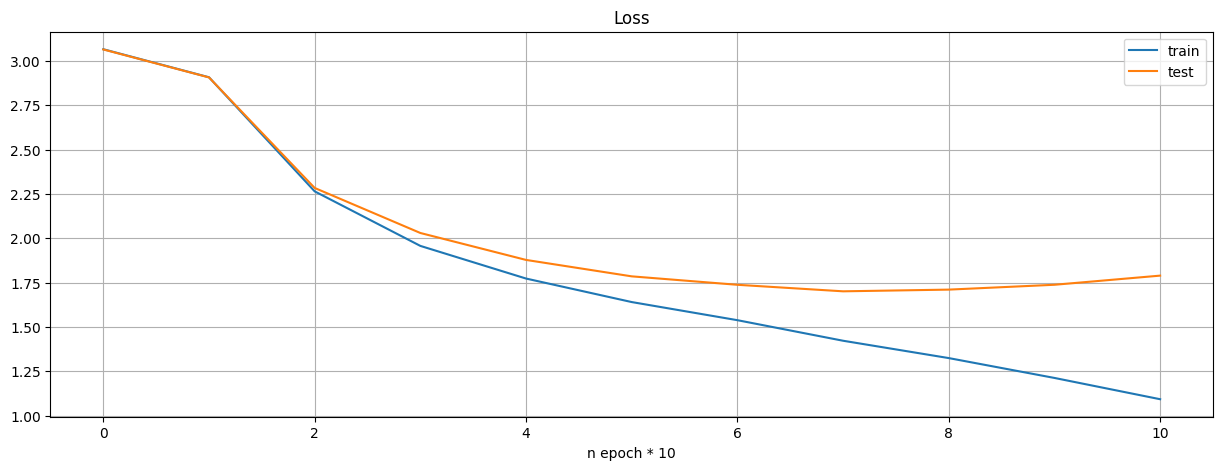

In [101]:
plot_train_process(train_loss, val_loss, epoch_gap)

In [104]:
# An example of generated text.
print(generate_sample(net, seed_phrase='programing ', max_length=500, temperature=0.2, lstm=True))

programing the farther than she disgrace:
  she hath the world with meauteous love some,
  to shade thee think of the prease, where thou art song,
    that the world not self the themp in one,
  that sin thee the world with all the world's pride,
  and steel the thenk in the subser tould,
  that i have speese of such a comperse
  which show heaven the restor thee thee grow,
  they with the trifious make my love and strong,
  that thou art self the strong of the preemented.
  then the strange of 


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [108]:
# Text generation with different temperature values here


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [116]:
# Saving and loading code here

torch.save(net.state_dict(), './model.pt')
loaded_model = CharLSTMLoop(len(tokens), rnn_num_units=512, emb_size=38).to(device)
loaded_model.load_state_dict(torch.load('./model.pt'))
loaded_model.eval()
print(generate_sample(loaded_model, max_length=500, lstm=True, seed_phrase='queen of island '))

queen of island seems to blast inventhes, knowes theer his pace,
    that by thy sweet beauty she incemments.
  then you heaven's te thy munuses beauty's inight,
  my jafe uasmen frow one ate this lears,
  thy ligk of leave, that love thie sich'd,
    of thee, myself exsul'd, and siger be,
  for all thee,-- hath my shaters as vane,
  of beauty should the sight and given spirit?

  co
  sithind wolthouling that unterth of my sowe,
  leise't thy ell bus with give of eyes have now hath:
  for me th


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)